# Week 2 (same exercises as in 'Likelihood')

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm 
import itertools
from iminuit import Minuit   
from scipy.optimize import minimize

# setting for plotting
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

In [2]:
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)

## Exercise 1

#### Defining the likelihood functions

In [3]:
def likelihood(x, mu, sigma):
    'Normalized Gaussian'
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-0.5 * (x - mu)**2 / sigma**2)

def loglikelihood(x, mu, sigma):
    'POSITIVE log likelihood'
    return np.sum(np.log(likelihood(x, mu, sigma)), axis=1)

#### Defining and sampling the Gaussian pdf

In [4]:
# Defining
num_samples = 50
mu_true = 0.2
sig_true = 0.1

# Sampling
x_samples = np.random.normal(mu_true, sig_true, num_samples)

#We will expand the first dimension of the x_samples array to enable execution of the log_likelihood function
#in the case when both x_samples and mu/sigma are arrays. All this does is that it changes the shape of x_samples
#from (num_samples,) to (1,num_samples).
x_samples = np.expand_dims(x_samples,axis=0)

#### Defining the grid for rasterscan

In [5]:
def rasterscan(x_samples, a_true, b_true, a_range, b_range, a_name, b_name):
    " Raster scan used in exercise 1: Plots positive llh with a log y scale "
    
    # 2D grid with all possible combinations of mu-sigma pairs
    grid = np.array(list(itertools.product(a_range,b_range)))
    
    # breaking down the a-b values in the 2D grid into separate arrays and expanding their axes to enable
    #arithmetic operations with x_samples.
    a_from_grid = np.expand_dims(grid[:,0],axis=1)
    b_from_grid = np.expand_dims(grid[:,1],axis=1)
    
    # evaluating the log_likelihood for all points in grid
    scanned_llh = loglikelihood(x_samples, a_from_grid, b_from_grid)

    #after the scan, we find the index in the flat scanned_llh array that gives us the maximum likelihood
    ind_max_llh = np.argmax(scanned_llh)

    # PLOT RESULT
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(111)

    # raster scan results
    sc = ax.scatter(a_from_grid, b_from_grid, c = scanned_llh, marker = 's', s = 100, vmin = 0, cmap = 'viridis')

    # the true value
    ax.plot(a_true, b_true, marker='*', color='red', markersize=15, ls='none', label = 'True value')

    #the maximum of the raster scan LLH
    ax.plot(a_from_grid[ind_max_llh], b_from_grid[ind_max_llh], marker = 'o', ls='none',
            color = 'black',markersize = 10, label = 'Maximum LLH from the scan')

    ax.set_yscale('log')
    ax.legend(loc = (0.1,0.8), labelcolor='w') 
    ax.set_xlabel(a_name)
    ax.set_ylabel(b_name)

    cb = fig.colorbar(sc,label='\nLLH')
    #put_ticks(fig,ax)
    
    return [a_from_grid[ind_max_llh], b_from_grid[ind_max_llh]]

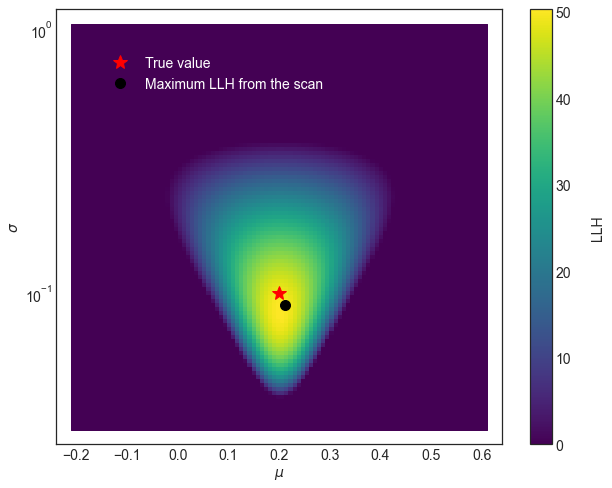

In [6]:
mu_range = np.linspace(-0.2,0.6,100)
sigma_range = np.logspace(-1.5,0,100)
mu_name = r'$\mu$'
sigma_name = r'$\sigma$'

mu_ras, sig_ras = rasterscan(x_samples, mu_true, sig_true, mu_range, sigma_range, mu_name, sigma_name)

#### Running multiple trials


In [7]:
def sample_and_scan(a_true, b_true, a_range, b_range, num_trials, num_samples):
    '''This function only works for Gaussian likelihoods'''
    
    # defining grid and seperate arrays for a and b
    grid = np.array(list(itertools.product(a_range,b_range)))
    a_from_grid = np.expand_dims(grid[:,0],axis=1)
    b_from_grid = np.expand_dims(grid[:,1],axis=1)
    
    # the placeholders for the raster scan LLH and the LLH assuming the truth
    scan_max_llh = []
    true_max_llh = []

    for i in (range(num_trials)):
        # drawing samples from the gaussian
        x_samples = np.random.normal(a_true, b_true, num_samples)
        x_samples = np.expand_dims(x_samples, axis=0)
        
        # performing the raster scan over the a-b grid 
        scanned_llh = loglikelihood(x_samples, a_from_grid, b_from_grid)
        
        # Calculating the LLH assuming the truth
        true_llh = loglikelihood(x_samples, np.expand_dims([a_true],axis=0), np.expand_dims([b_true],axis=0)).flatten()[0]
        
        #Storing the results as arrays
        scan_max_llh = np.append(scan_max_llh, np.max(scanned_llh))
        true_max_llh = np.append(true_max_llh, true_llh)
        
    return scan_max_llh, true_max_llh

#### 100 trials with 50 samples in each

In [8]:
num_trials = 100 # NB difference between number of samples and number of trials!
raster_llh_res, true_llh_res = sample_and_scan(mu_true, sig_true, mu_range, sigma_range, num_trials, num_samples)

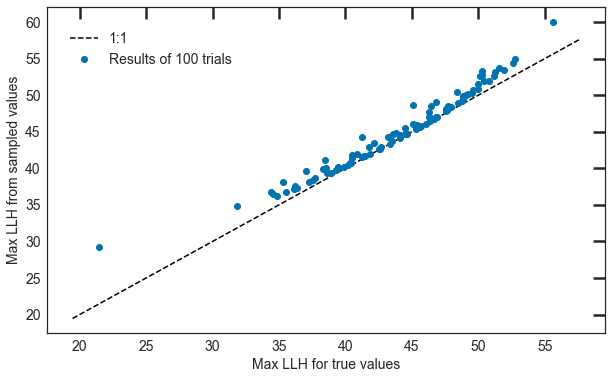

In [9]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

true_llh_arr = np.linspace(np.min(true_llh_res)-2,np.max(true_llh_res)+2,100)

ax.plot(true_llh_arr, true_llh_arr, ls='--', color = 'black', label = '1:1')
ax.plot(true_llh_res, raster_llh_res, 'o', label = 'Results of %s trials' %num_trials)

put_ticks(fig,ax)
ax.set_xlabel('Max LLH for true values')
ax.set_ylabel('Max LLH from sampled values')

ax.legend(loc = (0.03, 0.8));

### Exercise 2

#### Defining the likelihood functions

In [10]:
def likelihood(x, alpha, beta):
    # transform function into pdf (normalize!) and include limits for x (-1..1)
    func = 1 + alpha*x + beta*x**2 
    func_int = 2+(2*beta/3) 
    pdf = func / func_int
    pdf = np.where(np.abs(x) <= 1, pdf, 0.) 
    return pdf

def loglikelihood(x, alpha, beta):
    return np.sum(np.log(likelihood(x, alpha, beta)), axis = 1)

#### Monte Carlo simulation

**MC function: generates data and uses the accept / reject method**

In [11]:
def gen_MC(xrange, likelihood, parms, n_samples):
    '''Accept and reject MC
    Input: range of x-values, likelihood function, list of parameters and number of samples
    Output: accepted and rejected x and pdf values, pdf curve and efficiency '''

    pdf_curve = likelihood(xrange, *parms)
    max_value = np.max(pdf_curve) # upper boundary for the accept-reject box
    min_value = 0

    n_accept = 0
    n_reject = 0
    x_accept, x_reject, pdf_accept, pdf_reject = [], [], [], []
    
    while n_accept < n_samples:
        # generating data 
        x_sample = np.random.uniform(min(xrange), max(xrange))   # random x sample
        pdf_sample = np.random.uniform(min_value, max_value)     # random y/pdf sample
        evaluated_pdfs_at_x = likelihood(x_sample, *parms)       # evaluate pdf at x sample given likelihood
        
        # accept-reject test 
        if (pdf_sample <= evaluated_pdfs_at_x):     
            x_accept = np.append(x_accept, x_sample)
            pdf_accept = np.append(pdf_accept, pdf_sample)
            n_accept += 1
        else:
            x_reject = np.append(x_reject, x_sample)
            pdf_reject = np.append(pdf_reject, pdf_sample)        
            n_reject += 1

    eff = n_samples/(n_samples+n_reject)
    
    return x_accept, x_reject, pdf_accept, pdf_reject, pdf_curve, eff

**Define ranges and parameters and use the above MC function:**

In [12]:
xrange = np.linspace(-1, 1, 100)
alpha, beta, n_samples = 0.5, 0.5, 2000
parms = [alpha, beta]

x_accept, x_reject, pdf_accept, pdf_reject, pdf_curve, eff = gen_MC(xrange, likelihood, parms, n_samples)

**Plot result**

Efficiency = 0.589


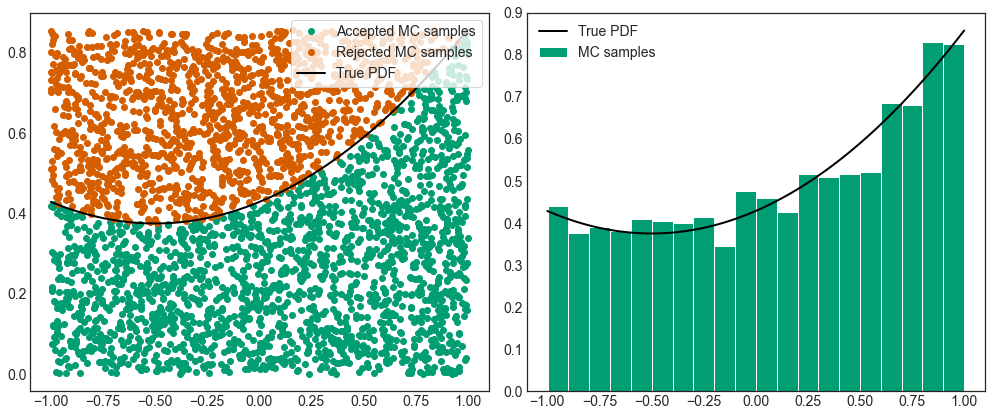

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(x_accept, pdf_accept, 'o', color = color[2], label = 'Accepted MC samples')
ax1.plot(x_reject, pdf_reject, 'o', color = color[3], label = 'Rejected MC samples')
ax1.plot(xrange, pdf_curve, color = 'black', lw=2, label = 'True PDF')
ax1.legend(frameon = True)

ax2.hist(x_accept, bins = 20, density = True, color=color[2], label = 'MC samples') 
ax2.plot(xrange,pdf_curve, ls = '-', color = 'black', lw = 2, label = r'True PDF')
ax2.legend()

fig.subplots_adjust(wspace=0.1)
fig.tight_layout()

print('Efficiency =', round(eff,3))

### Fitting the MC samples with Minuit

In [14]:
def llh_fit(data, likelihood, startparms, parmsnames, parmslimits=None, step=False):
    steps_taken = []
    
    def negloglikelihood(parms):
        '''Minuit needs a negative log likelihood function that only has the parameters as input'''
        steps_taken.append(parms) # appends the parameters for each step in fitting
        neg_llh = - np.sum(np.log(likelihood(data, *parms)))
        return neg_llh
    
    minuit_ullh = Minuit(negloglikelihood, startparms, name = parmsnames)
    
    if parmslimits:
        for i in range(len(parmslimits)):
            minuit_ullh.limits[i] = parmslimits[i]

    minuit_ullh.errordef = 0.5     # Value for likelihood fits
    minuit_ullh.migrad()           # Perform the actual fit
    
    if (not minuit_ullh.fmin.is_valid):
        print("  WARNING: The Unbinned Likelihood fit DID NOT converge!!! ")
    
    
    par = minuit_ullh.values[:]
    par_err = minuit_ullh.errors[:] 
    par_name = minuit_ullh.parameters[:]
    negativlogp_value = minuit_ullh.fval  
    Ndof_value = len(data) - minuit_ullh.nfit
    
    if step: 
        
        def find_nearest(a, a0):
            idx = np.abs(a - a0).argmin()
            return idx
    
        alpha_step = []
        beta_step = []
    
        for step in range(len(steps_taken)):
            alpha_step.append(alpha_range[find_nearest(alpha_range, steps_taken[step][0])])
            beta_step.append(beta_range[find_nearest(beta_range, steps_taken[step][1])])
        
        return par, par_err, alpha_step, beta_step

    else: 
        return par, par_err

#### Estimators

In [15]:
par, par_err = llh_fit(x_accept, likelihood, [alpha, beta], ['alpha', 'beta'], [(0,2), (0,2)])
print('Estimators using Minuit \nAlpha = %s pm %s \nBeta = %s pm %s' 
      %(round(par[0],2), round(par_err[0], 2), round(par[1], 2), round(par_err[1], 2)))

Estimators using Minuit 
Alpha = 0.47 pm 0.05 
Beta = 0.5 pm 0.1


### Fitting the MC samples with scipy optimize minimize

First, we will define the function that computes the negative log likelihood of observing our MC samples given some assumed parameters $\alpha$ and $\beta$. These appear as **params[0]** and **params[1]** below, respectively. This is done because [scipy.optimize.minimize] expects a vector of parameters as an input, rather than two scalars separately.


In [16]:
lambda_neg_LLH = lambda params: -loglikelihood(x_accept, np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))

Next, we move to the actual minimization of the -LLH function. We need to pass a seed (startguess) to the minimizer, which (given the truth of [0.5,0.5] we put to be [0.3,0.3] here.

In [17]:
res = minimize(lambda_neg_LLH, x0 = [0.3,0.3], bounds = ((-0.2,1),(0,1)), method='L-BFGS-B')
res

      fun: array([1319.32480302])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.04636308e-04, -6.82121023e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([0.46846342, 0.50198424])

Now, **res.x** contains the estimate of $\alpha$ and $\beta$ that **scipy.optimize.minimize** gave us.  What about the errors? Since we were minimizing the negative LLH, the inverse Hessian matrix returned by the fit (**res.hess_inv**) is the covariance matrix describing a gaussian approximation to the MLE. This means that we can compute the uncertainties as simply as:

In [18]:
errors = np.sqrt(np.diag(res.hess_inv.todense()))
errors

array([0.07901526, 0.29442161])

In [19]:
print('Estimators using Scipy optimize minimize \nAlpha = %s pm %s \nBeta = %s pm %s' 
      %(round(res.x[0],2), round(errors[0], 2), round(res.x[1], 2), round(errors[1], 2)))

Estimators using Scipy optimize minimize 
Alpha = 0.47 pm 0.08 
Beta = 0.5 pm 0.29


## Exercise 3

#### Generating data and plotting them to cross check that it looks valid

In [20]:
xrange = np.linspace(-1, 1, 100)
alpha, beta = 0.6, 0.5
parms = [alpha, beta]
n_samples = 2000
x_accept, x_reject, pdf_accept, pdf_reject, pdf_curve, eff = gen_MC(xrange, likelihood, parms, n_samples)

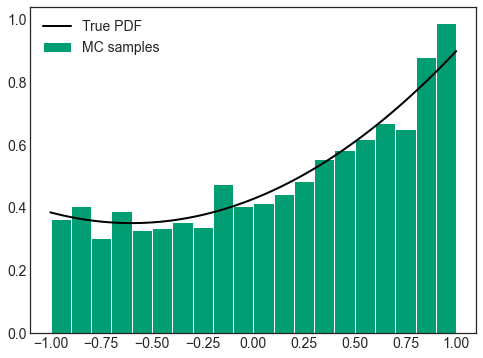

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(x_accept, bins = 20, density = True, color=color[2], label = 'MC samples') 
ax.plot(xrange,pdf_curve, ls = '-', color = 'black', lw = 2, label = r'True PDF')
ax.legend();

#### Determining estimators using Minuit

In [22]:
par, par_err = llh_fit(x_accept, likelihood, [alpha, beta], ['alpha', 'beta'], [(0,2), (0,2)])
print('Estimators using Minuit \nAlpha = %s pm %s \nBeta = %s pm %s' 
      %(round(par[0],2), round(par_err[0], 2), round(par[1], 2), round(par_err[1], 2)))

Estimators using Minuit 
Alpha = 0.65 pm 0.05 
Beta = 0.6 pm 0.11


#### Determining estimators using Scipy optimize minimize

In [23]:
lambda_neg_LLH = lambda params: -loglikelihood(x_accept, np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))
res = minimize(lambda_neg_LLH, x0 = [0.3,0.3], bounds = ((-0.2,1),(0,1)), method='L-BFGS-B')
errors = np.sqrt(np.diag(res.hess_inv.todense()))
print('Estimators using Scipy optimize minimize \nAlpha = %s pm %s \nBeta = %s pm %s' 
      %(round(res.x[0],2), round(errors[0], 2), round(res.x[1], 2), round(errors[1], 2)))

Estimators using Scipy optimize minimize 
Alpha = 0.65 pm 0.05 
Beta = 0.6 pm 0.11


#### Visualizing the likelihood landscape

**Raster scan function used in exercise 2**

In [31]:
def rasterscan(x_samples, a_true, b_true, a_range, b_range, a_name, b_name, ax):
    # 2D grid with all possible combinations of mu-sigma pairs
    grid = np.array(list(itertools.product(a_range,b_range)))
    
    # breaking down the a-b values in the 2D grid into separate arrays and expanding their axes to enable
    #arithmetic operations with x_samples.
    a_from_grid = np.expand_dims(grid[:,0],axis=1)
    b_from_grid = np.expand_dims(grid[:,1],axis=1)
    
    print(x_samples.shape, a_from_grid.shape, b_from_grid.shape)
    # evaluating the log_likelihood for all points in grid
    scanned_llh = loglikelihood(x_samples, a_from_grid, b_from_grid)

    #after the scan, we find the index in the flat scanned_llh array that gives us the maximum likelihood
    ind_max_llh = np.argmax(scanned_llh)

    # PLOT RESULT
    #fig = plt.figure(figsize = (10,8))
    #ax = fig.add_subplot(111)

    # raster scan results
    sc = ax.scatter(a_from_grid, b_from_grid, c = -2*scanned_llh+res.fun, marker = 's', s = 100, cmap = 'viridis')

    # the true value
    ax.plot(a_true, b_true, marker='*', color='red', markersize=15, ls='none', label = 'True value')

    #the maximum of the raster scan LLH
    ax.plot(a_from_grid[ind_max_llh], b_from_grid[ind_max_llh], marker = '*', ls='none',
            color = 'black',markersize = 15, label = 'Maximum LLH from the scan')
    
    contours = ax.contour(a_from_grid.reshape(len(a_range), len(b_range)),
                          b_from_grid.reshape(len(a_range), len(b_range)),
                          -2*(scanned_llh+res.fun).reshape(len(a_range), len(b_range)),
                          [2.3,4.5,6], colors=['white', 'grey', 'black']) # 2.3, 4.5 and 6 are C.L. for distributions
                                                                          # with two parameters

    ax.legend(loc = (0.1,0.8), labelcolor='w') 
    ax.set_xlabel(a_name)
    ax.set_ylabel(b_name)

    cb = fig.colorbar(sc,label='\nLLH')
    #put_ticks(fig,ax)
    
    return [a_from_grid[ind_max_llh], b_from_grid[ind_max_llh]]

**Fit data to get the parameter steps taken**

In [32]:
# define the ranges for the likelihood landscape
alpha_range = np.linspace(-0.2,1,100)
beta_range = np.linspace(0,1,100)

In [33]:
par, par_err, alpha_step, beta_step = llh_fit(x_accept, likelihood, [0.3, 0.3], ['alpha', 'beta'], step = True)

(2000,) (10000, 1) (10000, 1)


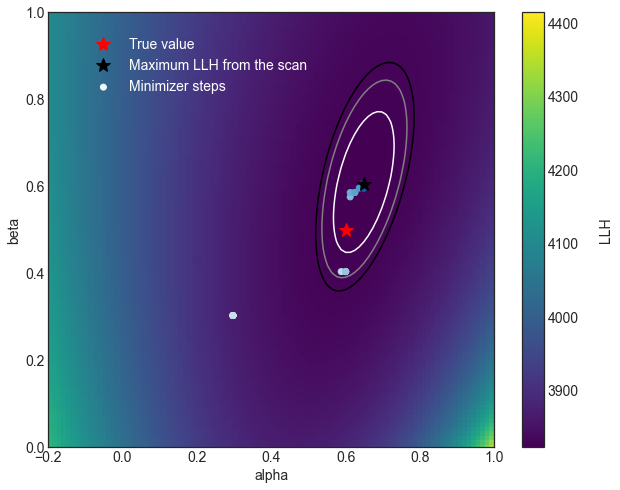

In [34]:


# color palette for the parameter steps taken
track_colors = sns.color_palette('Blues',len(alpha_step))

# plot result
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
rasterscan(x_accept, alpha, beta, alpha_range, beta_range, 'alpha', 'beta', ax)
ax.scatter(alpha_step, beta_step, color = track_colors, label = 'Minimizer steps')
ax.legend(loc = (0.08,0.8), labelcolor='w');